In [83]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from src.dtprocess import cleandt

## Import and Adjust data

In [5]:
vnexpress = pd.read_csv('./data/vnexpress/csv/cleaned_vnexpress.csv').drop(columns=['Unnamed: 0'], axis=1)
print(vnexpress.info())
vnexpress.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2474 entries, 0 to 2473
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  2474 non-null   int64 
 1   topic       2474 non-null   object
 2   sub-topic   2474 non-null   object
 3   tag         2474 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.4+ KB
None


,article_id,topic,sub-topic,tag
0,0,doi-song,to-am,xin_lỗi đi nhiều thế_hệ đã dùng câu này để xử_...
1,1,doi-song,to-am,một nghiên_cứu của đại_học wisconsinmadison mỹ...
2,2,doi-song,to-am,các yếu_tố như độ tuổi của trẻ mối quan_hệ giữ...
3,3,doi-song,to-am,ở tuổi đôi_mươi chị trần thị liên_kết_hôn với ...
4,4,doi-song,to-am,chị hoàng thị hòa 34 tuổi ở hà nam lấy chồng b...


In [6]:
news = vnexpress.copy()
label_encoder = LabelEncoder()
news['topic'] = label_encoder.fit_transform(vnexpress['topic'])
vnexpress['tag'] = vnexpress['tag'].apply(lambda x: cleandt.remove_stopword(x, './data/vietnamese-stopwords-dash.txt'))
news.head()

,article_id,topic,sub-topic,tag
0,0,0,to-am,xin_lỗi đi nhiều thế_hệ đã dùng câu này để xử_...
1,1,0,to-am,một nghiên_cứu của đại_học wisconsinmadison mỹ...
2,2,0,to-am,các yếu_tố như độ tuổi của trẻ mối quan_hệ giữ...
3,3,0,to-am,ở tuổi đôi_mươi chị trần thị liên_kết_hôn với ...
4,4,0,to-am,chị hoàng thị hòa 34 tuổi ở hà nam lấy chồng b...


In [7]:
vnexpress['topic'].value_counts()

topic
giai-tri    616
the-thao    508
khoa-hoc    449
doi-song    363
giao-duc    358
du-lich     180
Name: count, dtype: int64

## Split dataset into train and test

In [91]:
X = news[['tag']]
y = news[['topic']]
news_train, news_test, label_train, label_test = train_test_split(X, y, test_size=0.3, random_state=456)

In [92]:
print("The length of news_train: ", len(news_train), news_train.shape)
print("The length of news_test: ", len(news_test), news_test.shape)

The length of news_train:  1731 (1731, 1)
The length of news_test:  743 (743, 1)


In [93]:
print(label_train.value_counts())
print(label_test.value_counts())

topic
2        421
5        363
4        313
0        259
3        247
1        128
Name: count, dtype: int64
topic
2        195
5        145
4        136
3        111
0        104
1         52
Name: count, dtype: int64


## Re-present text data in numeric vector by pre-train Word2Vec model

In [87]:
def wordseparation(comment):
   tokens = comment.split()
   return tokens

In [105]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(news_train['tag'])
X_test = vectorizer.transform(news_test['tag'])

In [106]:
print(X_train.shape)
print(X_test.shape)

(1731, 31539)
(743, 31539)


In [107]:
print(X_train[0])

  (0, 7836)	0.03512112832697178
  (0, 23761)	0.013994802998077552
  (0, 29951)	0.045002515449863965
  (0, 10098)	0.01914977287822958
  (0, 25125)	0.024394326643463072
  (0, 10714)	0.011215665399623978
  (0, 6444)	0.045002515449863965
  (0, 24992)	0.02103347172378744
  (0, 20339)	0.018338201399431122
  (0, 2967)	0.042652280998050456
  (0, 25211)	0.026229867632798894
  (0, 878)	0.017809627090858763
  (0, 25117)	0.013246675726784935
  (0, 30910)	0.028248789548141758
  (0, 524)	0.03372325866305471
  (0, 12067)	0.00822581042199257
  (0, 30773)	0.015406457190169837
  (0, 12557)	0.03512112832697178
  (0, 22515)	0.045002515449863965
  (0, 28918)	0.03696701078446717
  (0, 25179)	0.045002515449863965
  (0, 26193)	0.007971913278211508
  (0, 4426)	0.06923355266530734
  (0, 10674)	0.06744651732610941
  (0, 18216)	0.00741503175899069
  :	:
  (0, 30708)	0.07474054217071781
  (0, 25907)	0.11939934064917311
  (0, 30540)	0.031348429612658116
  (0, 26294)	0.027380899947888032
  (0, 30817)	0.1348930346522

## Create text classification model by Naive Bayes

In [108]:
parameters = {'n_neighbors':[5, 7, 9, 10, 11, 13, 15, 17]}
knn = KNeighborsClassifier()

In [109]:
grid_mnb = GridSearchCV(estimator=knn, param_grid=parameters, cv=5, n_jobs=1, verbose=1)
grid_mnb.fit(X_train, label_train)

print("\n The best estimator across ALL searched params:\n", grid_mnb.best_params_)
print("\n The best score across ALL searched params:\n", grid_mnb.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


d:\Programming\Vietnamese-Text-Generator\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
d:\Programming\Vietnamese-Text-Generator\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
d:\Programming\Vietnamese-Text-Generator\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
d:\Programming\Vietnamese-Text-Generator\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-


 The best estimator across ALL searched params:
 {'n_neighbors': 11}

 The best score across ALL searched params:
 0.9098732321633822


d:\Programming\Vietnamese-Text-Generator\.venv\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [110]:
predictions = grid_mnb.predict(X_test)
print(mean_squared_error(label_test, predictions))

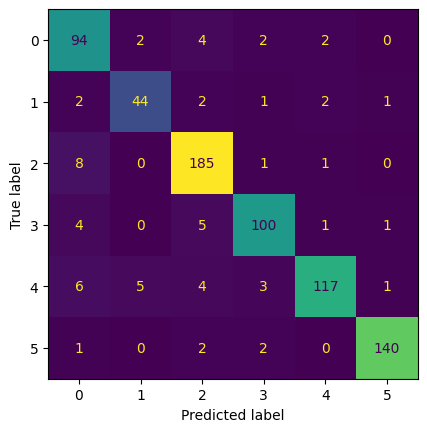

In [112]:
cm = confusion_matrix(label_test, predictions)
cfm = ConfusionMatrixDisplay(confusion_matrix=cm)
cfm.plot(colorbar=False)

In [113]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       104
           1       0.86      0.85      0.85        52
           2       0.92      0.95      0.93       195
           3       0.92      0.90      0.91       111
           4       0.95      0.86      0.90       136
           5       0.98      0.97      0.97       145

    accuracy                           0.92       743
   macro avg       0.91      0.90      0.90       743
weighted avg       0.92      0.92      0.92       743

